In [11]:
#siamese network

In [35]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from sklearn.neighbors import NearestNeighbors
import glob
import cv2
import numpy as np
import os
import shutil

# Load a few example images of the same kind
example_images_dir = "sample_images"
file_extension = ".jpg"
example_images = glob.glob(example_images_dir + "/*" + file_extension)

#siamese_move
def move(dataset_images_dir,new_des):
    num_jpg = len([f for f in os.listdir(dataset_images_dir) if f.endswith('.jpg')])
    similar_images = []
    for i in range(0,int(num_jpg/60)):
        dataset_images=glob.glob(dataset_images_dir + "/*" + file_extension)

        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        # Define Siamese network model
        input_a = Input(shape=(224, 224, 3))
        input_b = Input(shape=(224, 224, 3))

        flatten = Flatten()(base_model.output)
        dense = Dense(256, activation='relu')(flatten)
        embedding = Lambda(lambda x: K.l2_normalize(x, axis=1))(dense)

        siamese_model = Model(inputs=base_model.input, outputs=embedding)

        # Extract features from example images
        example_features = []
        for image_path in example_images:
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            feature = siamese_model.predict(image)
            example_features.append(feature)

        example_features = np.concatenate(example_features, axis=0)

        # Extract features from dataset images
        dataset_features = []
        for image_path in dataset_images:
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            feature = siamese_model.predict(image)
            dataset_features.append(feature)

        dataset_features = np.concatenate(dataset_features, axis=0)

        # Build a nearest neighbors model
        nn_model = NearestNeighbors(n_neighbors=50, metric='euclidean')
        nn_model.fit(dataset_features)

        # Find similar images for each example image
        for i in range(example_features.shape[0]):
            distances, indices = nn_model.kneighbors(example_features[i].reshape(1, -1))
            similar_images.extend([dataset_images[index] for index in indices.flatten()])

        # Remove duplicates and print similar image paths
        similar_images = list(set(similar_images))

        # print(similar_images)
        for image_path in similar_images:
            # Get the image file name
            image_file_name = os.path.basename(image_path)

            # Create the destination file path in the new folder
            destination_file_path = os.path.join(new_des, image_file_name)

            # Move the image file to the new folder
            shutil.move(image_path, destination_file_path)


#for training dataset
#for normal
dataset_images_dir="old/training/normal"
new_des="current/training/normal"
move(dataset_images_dir,new_des)

#for stone
dataset_images_dir="old/training/stone"
new_des="current/training/stone"
move(dataset_images_dir,new_des)

#for testing dataset
#for normal
dataset_images_dir="old/testing/normal"
new_des="current/testing/normal"
move(dataset_images_dir,new_des)

#for stone
dataset_images_dir="old/testing/stone"
new_des="current/testing/stone"
move(dataset_images_dir,new_des)


In [ ]:
#data augmentation and increase
pip install opencv-python

In [37]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from PIL import Image

def augment_images(input_dir, output_dir, aug_size):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

        
def add_noise(image):
    """
    Adds random Gaussian noise to an image.
    :param image: The input image as a NumPy array.
    :return: The image with added noise as a NumPy array.
    """
    noise = np.random.normal(0, 20, image.shape)
    noisy_image = np.clip((image + noise).astype('uint8'), 0, 255)
    return noisy_image


# Define the data generator with augmentation options
datagen = ImageDataGenerator(
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
) 

# Load the original images from a directory and apply data augmentation
def change(source_dir,dest_dir,num_augmented_images_per_orignal):
    for filename in os.listdir(source_dir):
        if filename.endswith('.jpg'): # Filter out non-image files
            img_path = os.path.join(source_dir, filename)
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=dest_dir, save_prefix=filename[:-4] + '_aug', save_format='jpg'):
                i += 1
                if i > num_augmented_images_per_original:
                    break


#for training                    
#for normal
source_dir = 'current/training/normal'
dest_dir = 'new/training/normal'
num_augmented_images_per_original = 1 # Set the number of augmented images you want to generate per original image
change(source_dir,dest_dir,num_augmented_images_per_original)

#for stone
source_dir = 'current/training/stone'
dest_dir = 'new/training/stone'
num_augmented_images_per_original = 3 # Set the number of augmented images you want to generate per original image
change(source_dir,dest_dir,num_augmented_images_per_original)


#for testing
#for normal
source_dir = 'current/testing/normal'
dest_dir = 'new/testing/normal'
num_augmented_images_per_original = 1 # Set the number of augmented images you want to generate per original image
change(source_dir,dest_dir,num_augmented_images_per_original)

#for stone
source_dir = 'current/testing/stone'
dest_dir = 'new/testing/stone'
num_augmented_images_per_original = 3 # Set the number of augmented images you want to generate per original image
change(source_dir,dest_dir,num_augmented_images_per_original)

In [ ]:
#deep learning model

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.utils import load_img, img_to_array
from keras.layers import Activation, Dense

# tf._version_


# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
training_set = train_datagen.flow_from_directory('new/training',target_size = (64, 64), batch_size = 20,class_mode = 'binary')

# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('new/testing', target_size = (64, 64),batch_size = 20,class_mode = 'binary')

# Part 2 - Building the CNN

# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

cnn.add(Dense(250))

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

Found 7206 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [2]:
# Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
history=cnn.fit(x = training_set, validation_data = test_set, epochs =15)

Epoch 1/15
361/361 [==============================] - 46s 124ms/step - loss: 0.2998 - accuracy: 0.8489 - val_loss: 0.1478 - val_accuracy: 0.9615
Epoch 2/15
361/361 [==============================] - 39s 107ms/step - loss: 0.0588 - accuracy: 0.9785 - val_loss: 0.0380 - val_accuracy: 0.9849
Epoch 3/15
361/361 [==============================] - 39s 108ms/step - loss: 0.0393 - accuracy: 0.9840 - val_loss: 0.0382 - val_accuracy: 0.9883
Epoch 4/15
361/361 [==============================] - 38s 107ms/step - loss: 0.0293 - accuracy: 0.9886 - val_loss: 0.0169 - val_accuracy: 0.9933
Epoch 5/15
361/361 [==============================] - 40s 111ms/step - loss: 0.0210 - accuracy: 0.9918 - val_loss: 0.0165 - val_accuracy: 0.9933
Epoch 6/15
361/361 [==============================] - 38s 106ms/step - loss: 0.0184 - accuracy: 0.9940 - val_loss: 0.0144 - val_accuracy: 0.9933
Epoch 7/15
361/361 [==============================] - 39s 107ms/step - loss: 0.0214 - accuracy: 0.9938 - val_loss: 0.0239 - val_ac

1/1 [==============================] - 0s 35ms/step
Accuracy: 0.9976019184652278
Precision: 1.0
Recall: 0.9947916666666666
F1 score: 0.9973890339425587


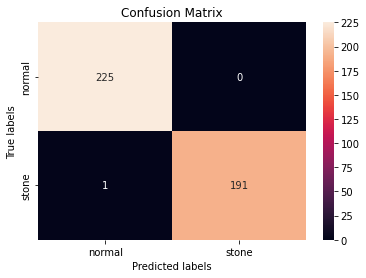

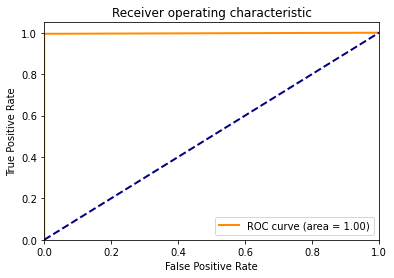

In [7]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score,roc_curve,auc
import seaborn as sns
import matplotlib.pyplot as plt  
test_labels = []
test_predictions = []

for batch_index in range(21):
    batch_images, batch_labels = test_set.next()
    batch_predictions = cnn.predict(batch_images).flatten()
    test_labels.extend(batch_labels)
    test_predictions.extend(batch_predictions)

# Convert the lists to numpy arrays
test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)

# Round the predictions to 0 or 1
test_predictions = np.round(test_predictions)

# Create a confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'stone']); ax.yaxis.set_ticklabels(['normal', 'stone']);

# Calculate the F1 score and other
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

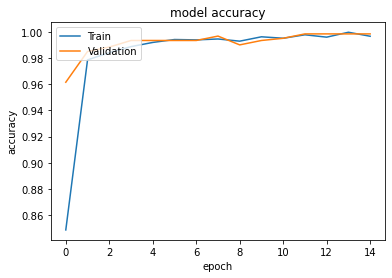

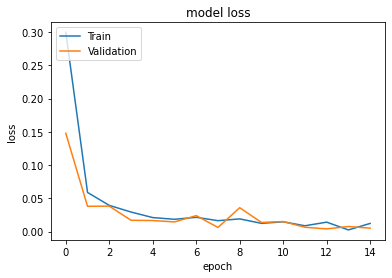

In [6]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#single prediction

In [12]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from sklearn.neighbors import NearestNeighbors
import glob
import cv2
import numpy as np
import os
import shutil
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from PIL import Image


def move(dataset_images_dir,new_des):
    num_jpg = len([f for f in os.listdir(dataset_images_dir) if f.endswith('.jpg')])
    similar_images = []
#     for i in range(0,int(num_jpg/10)):
    dataset_images=glob.glob(dataset_images_dir + "/*" + file_extension)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Define Siamese network model
    input_a = Input(shape=(224, 224, 3))
    input_b = Input(shape=(224, 224, 3))

    flatten = Flatten()(base_model.output)
    dense = Dense(256, activation='relu')(flatten)
    embedding = Lambda(lambda x: K.l2_normalize(x, axis=1))(dense)

    siamese_model = Model(inputs=base_model.input, outputs=embedding)

    # Extract features from example images
    example_features = []
    for image_path in example_images:
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        feature = siamese_model.predict(image)
        example_features.append(feature)

    example_features = np.concatenate(example_features, axis=0)

    # Extract features from dataset images
    dataset_features = []
    for image_path in dataset_images:
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        feature = siamese_model.predict(image)
        dataset_features.append(feature)

    dataset_features = np.concatenate(dataset_features, axis=0)

    # Build a nearest neighbors model
    nn_model = NearestNeighbors(n_neighbors=20, metric='euclidean')
    nn_model.fit(dataset_features)

    # Find similar images for each example image
    for i in range(example_features.shape[0]):
        distances, indices = nn_model.kneighbors(example_features[i].reshape(1, -1))
        similar_images.extend([dataset_images[index] for index in indices.flatten()])

    # Remove duplicates and print similar image paths
    similar_images = list(set(similar_images))

    # print(similar_images)
    for image_path in similar_images:
        # Get the image file name
        image_file_name = os.path.basename(image_path)

        # Create the destination file path in the new folder
        destination_file_path = os.path.join(new_des, image_file_name)

        # Move the image file to the new folder
        shutil.move(image_path, destination_file_path)


        
        
        
#change         
#is 
#below


datagen = ImageDataGenerator(
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
) 

# Load the original images from a directory and apply data augmentation
def change(source_dir,dest_dir):
    for filename in os.listdir(source_dir):
        if filename.endswith('.jpg'): # Filter out non-image files
            img_path = os.path.join(source_dir, filename)
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=dest_dir, save_prefix=filename[:-4] + '_aug', save_format='jpg'):
                i += 1
                if i > 0:
                    break

                    
        
example_images_dir = "sample_images"
file_extension = ".jpg"
example_images = glob.glob(example_images_dir + "/*" + file_extension)


dataset_images_dir="old_single/old"
new_des="old_single/updated"
final_des="new_single"
# num_augmented_images_per_orignal=1
move(dataset_images_dir,new_des)
change(new_des,final_des)
num_jpg = len([f for f in os.listdir(final_des)])
count_st=0
count_no=0
for i in range(0,num_jpg):
    test_image = tf.keras.utils.load_img('new_single//' + os.listdir("new_single/")[i], target_size = (64, 64))
    test_image = tf.keras.utils.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image)
    training_set.class_indices
    if result[0][0] ==1:
        count_st=count_st+1
#         print('stone')
    else:
        count_no=count_no+1
#         print('normal')
if count_st>count_no:
    print("Stone")
else:
    print("Normal")
    

filelist = glob.glob(os.path.join(final_des, "*"))
for f in filelist:
    os.remove(f)

1/1 [==============================] - 1s 503ms/step


KeyboardInterrupt: 